# Assignment 1

**Course:** AI in Health Technologies (ELEC-E8739), Fall 2025

**Instructor:** Prof. Aleksei Tiulpin, PhD


## 1. About

The idea of the present assignment is to practice the basic machine learning concepts we studied in Module 1. By completing the assignment, you will learn how to:

1) **Conduct** a scientific numerical experiment that analyzes how hyperparameters affect model performance and stability.  
2) **Visualize** experimental results using PCA.  
3) **Conduct** a statistical test to analyze your results.  

Please first read Section 2, which describes the clinical problem. Then, look at Section 3, where you need to fill in the blanks. Read all the descriptions of the blocks carefully.  


## 2. Clinical Problem

### 2.1 Knee Osteoarthritis Progression Prediction
Today, we will make use of the recently downloaded OAI dataset. OAI stands for the Osteoarthritis Initiative, and it is one of the best datasets available for this purpose.

Chronic diseases are known to place a heavy burden on society, and one specific case is knee osteoarthritis (KOA). This is a joint disease characterized by loss of integrity, inflammation, and stiffness.

Here is a graphical illustration of how a knee joint may look with and without OA:


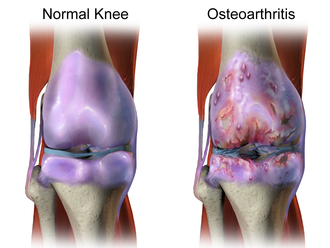

When it comes to OA, one of the most critical problems is predicting knee OA progression. The research question we aim to address is:

> Can we identify subjects who will develop the disease faster than others?

This naturally resembles the time-to-event problem we discussed in Lecture 4. In cases where the horizon is fixed, and we only predict the probability of an event occurring *by* a certain point (rather than *after* it), we can resort to classification:

$$p(t \in (0, T] \mid \mathbf{x}) = p(y = 1 \mid \mathbf{x}),$$

where $y$ is a binary variable indicating whether the event has occurred in $(0, T]$ or not.  
The biggest challenge here is deciding which algorithm to choose. This is exactly what we will explore.  


## 2.2 X-ray imaging

There are various types of data that can be used to predict KOA progression. One of them is X-ray imaging. Before we go into progression, we should figure out how the disease is staged (graded according to the severity). In X-rays, we use the **Kellgren-Lawrence (KL)** grading system for this purpose. Here is the breakdown of the grades:

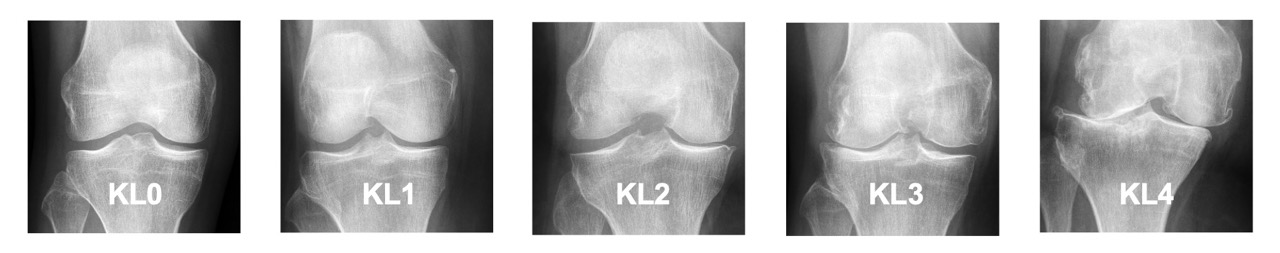

We can naturally use this way of knee joint assessment to measure the disease progression. If there is an increase in the KL grade between two time points, then we can qualify this as a progressed disease.


There are several other, more fine-grained ways to measure if the disease would progress or not. One of them is the fixed joint space width, where we specifically target measurement of joint space width at a fixed anatomical location. Another way to stage the disease involves grading of individual KOA features, and it is known as OARSI grading atlas.


Defining and predicting KOA progression remains a challeneging problem, and many have tried to address it. In this assignment, you will join this group of scientists, and will investigate wither it is possible to predict the disease in people who show now signs of OA in an X-ray, and use machine learning to predict if a particular person will have the disease progression. We note that the conventional approach involves modelling progression for 1 knee at the time. What you will do, is the prediction of progression in **both knees** within the next **9 years**. That is, we are building the model

$$p(t \in (0, 9] \mid \mathbf{x}_L, \mathbf{x}_R),$$


and to achieve this, you will use a Random Forest. We will be exploring, how stable our predictive model is, and conducting a statsitical test to back up our conclusions.



### 2.3 Data preparation

As mentioned earlier, we will be using the OAI dataset. By now, you should have downloaded it from the website. If you have any troubles with the dataset access, you should immediately contact the instructor. OAI dataset is being approved automatically, and you can just dowload the data.

For this assignment, you will need several files from the OAI.:

1. `AllClinical00.txt` - clinical data from a patient.
2. `Enrollees.txt` - Basic information from all patients.
3. `KXR_SQ_BU00.txt`- Knee OARSI grades
4. `OUTCOMES99.txt` - Outcomes

The model you will be building will include the following data:

1. AGE
2. SEX
3. RACE
4. BMI
6. Baseline Joint Space Width Narrowing OARSI scores (2x left and 2x right).
7. Family history of total knee replacement
8. Family history of total hip replacement
9. Knee injury history (L)
10. Knee injury history (R)
11. WOMAC pain score (L)
12.  WOMAC pain score (R)
13. WOMAC disability score (L)
14. WOMAC disability score (R)
16. Indicator of limited / avoided activity due to stiffness and pain


You can find the exact variable codes in pdf that accompany OAI dataset.

## 3. Code

### 3.1 Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
import random
import pathlib

### 3.2 Data curation



The first part of this assignment will involve reading data manuals and building the dataset for the progression prediction problem. You will need to read data and prepare dataframes with pandas. We advise you to utilize Google Colab capabilities to store and read data on Google Drive.

In [2]:
# This will mount your google drive folder
from google.colab import drive

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


Verify that you have data in place:

In [13]:
!ls /content/drive/MyDrive/Colab\ Notebooks/OAI_data

AllClinical00.txt  Enrollees.txt	  kxr_qjsw_duryea05.txt  OUTCOMES99.txt
Clinical_FNIH.txt  kxr_qjsw_duryea00.txt  KXR_SQ_BU00.txt


In [15]:
base_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/OAI_data")
enrolees = pd.read_csv(base_path / "Enrollees.txt", dtype={"ID": str}, sep="|")

# Patient level information
clinical = pd.read_csv(base_path / "AllClinical00.txt", dtype={"ID": str}, sep="|")
xr_gradings = pd.read_csv(base_path / "KXR_SQ_BU00.txt", dtype={"ID": str, "SIDE": str}, sep="|")
outcomes = pd.read_csv(base_path / "OUTCOMES99.txt", dtype={"id": str}, sep="|")

Let us first get the variables we need and do some renaming and also take data that makes sense to take. OAI has different reading projects, and they need to be curated to ensure data consistency.


**Note:** You do not need to do anything here except running the code.

In [16]:
# We should pull data from BOTH KNEES at the same time, at a patient level.
# This will build a patient-level dataset
enrolees = enrolees[["ID", "P02SEX", "P02RACE"]]
enrolees.replace({col: val for col, val in zip(['1: White or Caucasian', '2: Black or African American',
                                                '0: Other Non-white',
                                                '3: Asian'], range(4))}, inplace=True)

clinical = clinical[["ID",  "V00AGE", "P01BP30", "P01BMI", "P01BP30", "P01FAMHR", "P01FAMKR", "P01INJR",
                     "P01INJL", "P01KPACDCV", "V00WOMKPL", "V00WOMADLL", "V00WOMKPR", "V00WOMADLR"]]


# Fixng the clinical data
clinical = pd.merge(clinical, enrolees, on="ID")
mask_na_clinical = (clinical == ".: Missing Form/Incomplete Workbook").any(axis=1)
clinical = clinical[~mask_na_clinical].reset_index(drop=True)

In [17]:
# Curating the OARSI grades for each knee
imaging_features = ["V00XRKL", "V00XRJSL", "V00XRJSM"]

# Fixing metadata
xr_gradings["SIDE"] = xr_gradings["SIDE"].replace({"2: Left": "L", "1: Right": "R"})


# Taking the most reliable OARSI graidngs for the baseline
oarsi_grades = xr_gradings.loc[xr_gradings.READPRJ == 15, ["ID", "SIDE", "READPRJ"] + imaging_features].dropna().reset_index(drop=True)
oarsi_grades.replace({"0: 0": 0, "1: 1": 1, "2: 2": 2, "3: 3": 3, "4: 4": 4}, inplace=True)

mask_na_oarsi = (oarsi_grades == ".: Missing Form/Incomplete Workbook").any(axis=1)
oarsi_grades = oarsi_grades[~mask_na_oarsi].reset_index(drop=True)
oarsi_grades[imaging_features] = oarsi_grades[imaging_features].astype(int)

/tmp/ipython-input-558991992.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oarsi_grades.replace({"0: 0": 0, "1: 1": 1, "2: 2": 2, "3: 3": 3, "4: 4": 4}, inplace=True)


We can now take the dataset that includes data for two knees at the time, and build a patient level dataset:

In [18]:
right_knees = oarsi_grades[oarsi_grades.SIDE == "R"].copy()
right_knees.rename({c: f"{c}_R" for c in right_knees.columns[2:]}, axis=1, inplace=True)

left_knees = oarsi_grades[oarsi_grades.SIDE == "L"].copy()
left_knees.rename({c: f"{c}_L" for c in left_knees.columns[2:]}, axis=1, inplace=True)


left_knees.drop("SIDE", axis=1, inplace=True)
right_knees.drop("SIDE", axis=1, inplace=True)

merged_imaging_baseline = pd.merge(left_knees, right_knees, on="ID")
merged_imaging_baseline.head()

,ID,READPRJ_L,V00XRKL_L,V00XRJSL_L,V00XRJSM_L,READPRJ_R,V00XRKL_R,V00XRJSL_R,V00XRJSM_R
0,9000099,15,3,2,0,15,2,0,0
1,9000296,15,3,0,2,15,2,0,1
2,9000622,15,1,0,0,15,1,0,0
3,9000798,15,4,0,3,15,1,0,1
4,9001104,15,1,0,1,15,3,0,2


In [19]:
merged_imaging_baseline.shape

(4431, 9)

In [20]:
# Removing incomplete outcome data
outcomes = outcomes.loc[outcomes.V99RNTCNT != '.: Missing Form/Incomplete Workbook']
outcomes = outcomes.loc[outcomes.V99ERXIOA != '.: Missing Form/Incomplete Workbook']
outcomes = outcomes.loc[outcomes.V99ELXIOA != '.: Missing Form/Incomplete Workbook']

In [21]:
ds_outcomes = outcomes.loc[(outcomes[["V99ERXIOA", "V99ELXIOA"]] != "1: KL>=2 at BL").all(1), ["id", "V99ERXIOA", "V99ELXIOA"]]
prog_kl = ds_outcomes.loc[(ds_outcomes[["V99ERXIOA", "V99ELXIOA"]] != "2: KL0-1 at BL, follow-up x-rays but no incident KL >= 2").any(axis=1)]

We can now finally add the clinical data:

In [22]:
# Merging the clinical data
multimodal = pd.merge(merged_imaging_baseline, clinical)

multimodal = multimodal.replace({'1: Yes': 1, '0: No': 0, "1: Male": 1, "2: Female": 0, "2: Limits": 2, '1: Avoids': 1, '0: No Limits or avoidance': 0})
multimodal = multimodal.dropna()
multimodal = pd.get_dummies(multimodal, columns=["P02RACE"])
multimodal.head()

/tmp/ipython-input-2941429493.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  multimodal = multimodal.replace({'1: Yes': 1, '0: No': 0, "1: Male": 1, "2: Female": 0, "2: Limits": 2, '1: Avoids': 1, '0: No Limits or avoidance': 0})


,ID,READPRJ_L,V00XRKL_L,V00XRJSL_L,V00XRJSM_L,READPRJ_R,V00XRKL_R,V00XRJSL_R,V00XRJSM_R,V00AGE,...,P01KPACDCV,V00WOMKPL,V00WOMADLL,V00WOMKPR,V00WOMADLR,P02SEX,P02RACE_0,P02RACE_1,P02RACE_2,P02RACE_3
0,9000099,15,3,2,0,15,2,0,0,59,...,20.0,0.0,0.0,1.0,10.0,1,True,False,False,False
1,9000296,15,3,0,2,15,2,0,1,69,...,0.0,0.0,0.0,0.0,0.0,1,True,False,False,False
2,9000622,15,1,0,0,15,1,0,0,71,...,15.0,0.0,0.0,3.0,14.9,0,True,False,False,False
3,9000798,15,4,0,3,15,1,0,1,56,...,0.0,8.0,17.0,0.0,0.0,1,True,False,False,False
4,9001104,15,1,0,1,15,3,0,2,72,...,21.0,0.0,10.0,4.0,25.0,0,True,False,False,False


In [23]:
multimodal.loc[multimodal.ID.astype(str).isin(ds_outcomes["id"].unique()), "PROG"] = 0
multimodal.loc[multimodal.ID.astype(str).isin(prog_kl["id"].unique()), "PROG"] = 1

multimodal.dropna(inplace=True)
multimodal.shape

(1841, 28)

In [24]:
X = multimodal.drop(columns=["ID", "PROG", "READPRJ_L", "READPRJ_R"]).values.astype(float)
y = multimodal["PROG"].values.astype(int)

### 3.3 Task 1: building a simple cross-validation loop (4 points)

Let's start by using defaults. You first task will be to build a cross validation loop and evaluate the model performance. Follow the instructions below:

In [25]:
#### YOUR CODE STARTS HERE ####

# Points: 2 points

# Remember to use correct cros-validation procedure (look at the data distribution; is it valid to use KFold as is?)
# Remember to fix the random seeds
# Store the predictions and the ground truth in separate vectors -- `gt_all` and `preds`.

# for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# verify data distribution
unique, counts = np.unique(y, return_counts=True)
print("Number of samples in each class:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")
print("The data is imbalanced, so we should use StratifiedKFold instead of KFold")

# the data is imbalanced, so we should use StratifiedKFold instead of KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# initialize ground truth and predictions lists
gt_all = []
preds = []

# perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # initialize the model
    # model = DecisionTreeClassifier(random_state=SEED, class_weight="balanced")
    model = RandomForestClassifier(
        n_estimators=10,
        random_state=SEED,
        max_depth=5,
        min_samples_split=10,
        n_jobs=-1
    )

    # fit the model
    model.fit(X_train, y_train)

    # find the index of the positive class (assuming positive = 1)
    pos_idx = np.where(model.classes_ == 1)[0][0]
    # use predict_proba to get probabilities
    y_pred_proba = model.predict_proba(X_test)[:, pos_idx]

    # store the ground truth and predictions
    gt_all.extend(y_test.tolist())
    preds.extend(y_pred_proba.tolist())

#### YOUR CODE ENDS HERE ####

Number of samples in each class:
Class 0: 1426 samples
Class 1: 415 samples
The data is imbalanced, so we should use StratifiedKFold instead of KFold


If you managed with the task above, you will see these scores:

In [26]:
print(f"ROC AUC: {roc_auc_score(gt_all, preds):.2f}")
print(f"Average Precision: {average_precision_score(gt_all, preds):.2f}")

ROC AUC: 0.73
Average Precision: 0.44


Let us now plot the data. Try to replicate the plot as close as possible.

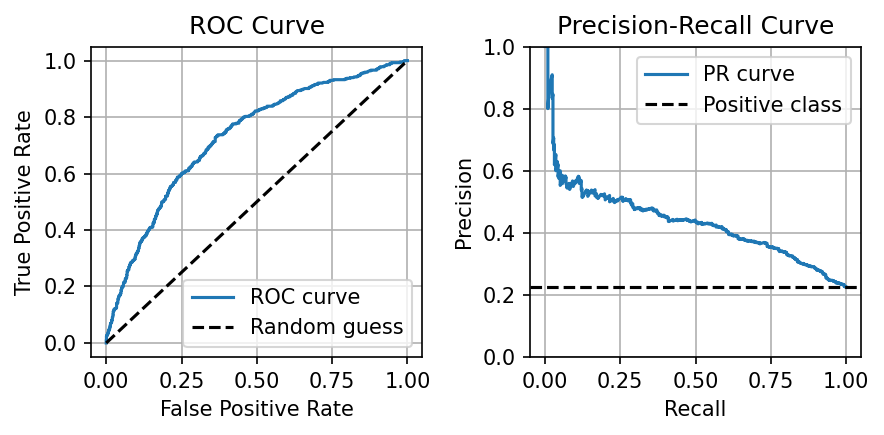

In [27]:
#### YOUR CODE STARTS HERE ####

# Points: 1 point

# The figure parameters are: figsize=(6, 3), dpi=150

# plot ROC and Precision-Recall curves side by side
fpr, tpr, _ = roc_curve(gt_all, preds)
precision, recall, _ = precision_recall_curve(gt_all, preds)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150)

# ROC curve
axes[0].plot(fpr, tpr, label='ROC curve')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_xlim([-0.05, 1.05])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid()

# Precision-Recall curve
positive_prevalence = np.mean(gt_all)
axes[1].plot(recall, precision, label='PR curve')
axes[1].axhline(y=positive_prevalence, color='k', linestyle='--', label='Positive class')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([0, 1])
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='upper right')
axes[1].grid()

plt.tight_layout()
plt.show()

#### YOUR CODE ENDS HERE ####

What can you conclude from these plots in terms of performance and the effect of hyperparameters on them (you need to try several different ones)?

Write a short response below.

In [28]:
#### YOUR ANSWER STARTS HERE ####
#
# Points: 1 point
#
# Write your observations.
#
# The grading criteria / guiding questions:
# 1. Does the student understand what the curves mean in terms of the actual clinical use?
# 2. Are the models useful? If so, when?
# 3. How does the performance change if you decrease the number of trees in RF / change depth?

# The ROC curve illustrates how the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) changes as the decision threshold varies. The ideal performance corresponds to the top-left corner (0,1), where sensitivity is close to 1 and false positives are close to 0.

# A curve close to the diagonal line (shown as the dashed line) indicates that the model has little discriminative ability, similar to random guessing. In contrast, a curve that bends strongly towards the top-left corner suggests that the model contains useful information.
# In our case, the ROC curve bends towards the optimal region, with an AUC around 0.7. This indicates moderate discrimination: the model is better than chance, but not yet robust enough for direct clinical application. Its usefulness would depend on the medical context and the consequences of false positives and negatives.
# The ROC curve itself does not provide the optimal probability threshold. This threshold can instead be computed using specific criteria such as Youden’s index, the minimal distance to the point (0,1), or by maximizing F1. In clinical practice, the choice of threshold is critical because it directly controls the trade-off between missed diagnoses (false negatives) and false positives.
# Regarding model complexity, increasing the number of trees mainly reduces variance by averaging across multiple estimators, without substantially affecting bias. In contrast, increasing tree depth has the opposite effect: deeper trees reduce bias by capturing more complex patterns in the data, but at the cost of higher variance and a greater risk of overfitting to noise.

# The Precision–Recall (PR) curve illustrates the trade-off between precision (TP / (TP + FP)) and recall (TP / (TP + FN)) as the decision threshold varies. The ideal performance corresponds to the top-right corner (1,1), where both metrics are high.
# This curve is particularly informative in imbalanced classification settings, such as ours, because it focuses on the positive class (in our case, the minority class). The dashed line represents the prevalence of the positive class in the dataset: the level of precision that would be obtained by random guessing. A useful model should achieve a PR curve that remains significantly above this line.
# Compared to the ROC curve, the PR curve provides a clearer view of performance in the presence of class imbalance. A model that always predicts the majority class may achieve an high ROC AUC value, but its precision for the minority class would be very low.
# Our PR curve shows that the model performs substantially better than chance, with an average precision of 0.44 compared to the baseline of approx 0.2. While this indicates that the model has predictive value, the performance is still moderate and may not be sufficient for clinical deployment without further improvements. Increasing model complexity (the number of trees, maximum depth, or minimum samples per split) can improve discrimination, but only up to a point in which the risk of overfitting grows.

#### YOUR ANSWER ENDS HERE ####

### 3.4 Task 2: Hyperparameter space (6 points)

Ok, now we get to the actual problem. Let us investigate how stable Random Forest is to different hyperparameters compared to e.g. Decision Tree. This is how we will do it.

In [29]:
def sample_params():
    #### YOUR CODE STARTS HERE ####
    #
    # Points: 2 points
    #
    # Design a function that can be used to sample hyperparameters from a space of hyperparameters at random
    #
    # Common hyperparameters for both DT and RF: max_depth, min_samples_split, min_samples_leaf, max_features
    # For RF, we'll fix n_estimators=50 for the speed of experiments.
    #
    # We recommend setting:
    # max depth to be between 1 and 20,
    # min_samples_split betweeen 2 and 20
    # min_samples_leaf between 1 and 20
    # max_features to sqrt / log2 (see class interface), as well as 10 options for fractions (10%-100% of features)
    #
    # Below is an example of how this function should work.

    # max_depth 1..20
    max_depth = np.int64(random.randint(1, 20))

    # min_samples_split 2..20
    min_samples_split = np.int64(random.randint(2, 20))

    # min_samples_leaf 1..20
    min_samples_leaf = np.int64(random.randint(1, 20))

    # max_features: choose between "sqrt", "log2" or fraction 0.1..1.0
    frac_options = [i/10 for i in range(1, 11)]
    mf_options = ["sqrt", "log2"] + frac_options
    mf_choice = random.choice(mf_options)
    max_features = np.float64(mf_choice) if isinstance(mf_choice, float) else mf_choice

    return {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features
    }

    #### YOUR CODE ENDS HERE ####

In [30]:
sample_params()

{'max_depth': np.int64(4),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(9),
 'max_features': np.float64(0.2)}

Let us now accumulate data on how a Decision Tree Classifier behavies with diferent values of hyperparameters.

In [31]:
def eval_classifier(clf_class, sample_params, n_samples=100):
    #### YOUR CODE STARTS HERE ####
    #
    # Points: 3 points
    #
    # Implement a function that
    # 0. Takes a classifier class and the sampling funtion as inputs
    # 1. Runs a for-loop
    # 2. Samples random hyperparameters for a classifier using the sampling function
    # 3. Runs an appropriate cross-validation loop to evaluate the mean score of the classifier
    # 4. Stores the scores in a pandas dataframe
    # 5. Returns the dataframe
    #
    # Once you have implemented the function,
    # you can evaluate it for both: Decision Tree and Random Forest

    results = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # 1. runs a for-loop
    for i in range(n_samples):
        # 2. samples random hyperparameters for a classifier using the sampling function
        params = sample_params()
        kwargs = dict(params) # unpacking dictionary to pass as arguments
        kwargs['random_state'] = SEED

        # initialize model
        model = clf_class(**kwargs)

        # 3. runs an appropriate cross-validation loop to evaluate the mean score of the classifier
        scores = cross_validate(model, X, y, cv=skf, scoring=['roc_auc', 'balanced_accuracy', 'average_precision', 'f1'])
        # extract test scores (array of scores for each fold)
        # get roc_auc scores
        roc_auc_scores = scores['test_roc_auc']

        # compute mean and std
        mean_score = np.mean(roc_auc_scores)
        std_score = np.std(roc_auc_scores)

        # 4. stores the scores in a pandas dataframe
        results.append({
            'max_depth': params["max_depth"],
            'min_samples_split': params["min_samples_split"],
            'min_samples_leaf': params["min_samples_leaf"],
            'max_features': params["max_features"],
            'mean_score': mean_score, # roc_auc
            'std_score': std_score, # roc_auc
            'balanced_accuracy': np.mean(scores['test_balanced_accuracy']),
            'average_precision': np.mean(scores['test_average_precision']),
            'f1': np.mean(scores['test_f1'])
        })

    # convert results to DataFrame
    return pd.DataFrame(results)

    #### YOUR CODE ENDS HERE ####

In [32]:
dt_df = eval_classifier(DecisionTreeClassifier, sample_params, 100)
print("Decision Tree Results:")
dt_df.head()

Decision Tree Results:


,max_depth,min_samples_split,min_samples_leaf,max_features,mean_score,std_score,balanced_accuracy,average_precision,f1
0,8,6,4,0.9,0.584864,0.012034,0.560294,0.302305,0.292830
1,18,4,19,0.5,0.675636,0.037799,0.553792,0.364968,0.245379
2,2,2,3,0.2,0.556161,0.016439,0.516166,0.277012,0.064902
3,8,18,20,sqrt,0.648298,0.047362,0.537244,0.335580,0.187423
4,18,8,18,0.5,0.657251,0.037934,0.546720,0.340598,0.227089


In [33]:
#### YOUR CODE STARTS HERE ####
#
# Points: 1 point
#
# Implement a subclass of RandomForestClassifier, called StableRF, which would
# Fix the number of trees (n_estimators) to 50
# Make sure that the classifier does not run the jobs of tree fitting in parallel
# The above is needed for our `eval_classifier` function to work.

class StableRF(RandomForestClassifier):
    def __init__(
        self,
        n_estimators=50, # forced value to 50
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=1, # forced value to 1
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
    ):
        super().__init__(
            n_estimators=50,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=1,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples,
        )

    def set_params(self, **params):
        # remove any attempts to change n_estimators or n_jobs
        params.pop('n_estimators', None)
        params.pop('n_jobs', None)
        return super().set_params(**params)

#### YOUR CODE ENDS HERE ####

In [34]:
rf_df = eval_classifier(StableRF, sample_params, 100)
print("Random Forest Results:")
rf_df.head()

Random Forest Results:


,max_depth,min_samples_split,min_samples_leaf,max_features,mean_score,std_score,balanced_accuracy,average_precision,f1
0,8,5,12,0.7,0.727001,0.032046,0.547693,0.419097,0.205953
1,14,6,8,0.1,0.724112,0.026638,0.503264,0.436281,0.014286
2,6,15,1,0.1,0.724832,0.030101,0.508586,0.445408,0.037484
3,11,15,8,0.3,0.724214,0.033355,0.529504,0.424063,0.148983
4,6,5,13,sqrt,0.725471,0.029488,0.506328,0.426656,0.032178


### 3.5. Task 3: Experiment visualization (4 points)

In [35]:
# This is a helper function to make sure we have all categorical values encoded properly
# These values are basically the numeber of features

def encode_max_features(df):
    mapping = {'sqrt': -1, 'log2': -2}
    df['max_features_num'] = df['max_features'].apply(lambda x: mapping.get(x, x))
    return df

dt_df = encode_max_features(dt_df)
rf_df = encode_max_features(rf_df)

# Features for PCA
features = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features_num']

#### YOUR CODE STARTS HERE ####
#
# Points: 3 points
# Using your knowledge from the course, implement the principal component analysis.
# Your implementation must be from scratch!!
# DO NOT use scikit learn, you will not get any points.
#
# As a reminder, features need to be scaled here, since we work with data that has different
# measurement units.
#
# You just need two components. See the next cell for the expected object names.
#
# `dt_pca` stores the matrix for the decision tree results and `rf_pca`
# stores the matrix for random forest

def pca(data, n_components=2):
    # compute covariance matrix
    cov_matrix = (1 / (data.shape[0] - 1)) * (data.T @ data)

    # compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # using SVD
    # U, S, Vt = np.linalg.svd(data, full_matrices=False)
    # eigenvalues = S**2 / (data.shape[0] - 1)
    # eigenvectors = Vt.T

    # order eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    n_components = min(n_components, data.shape[1])
    components = eigenvectors[:, :n_components]
    explained_variance = eigenvalues[:n_components]

    return components, explained_variance

# scale features using sklearn
# dt_df_scaled = StandardScaler().fit_transform(dt_df[features].values)
# scale feature without using sklearn
mean = np.mean(dt_df[features].values, axis=0)
std = np.std(dt_df[features].values, axis=0)
dt_df_scaled = (dt_df[features].values - mean) / std
# compute PCA
dt_components, dt_explained_variance = pca(dt_df_scaled, n_components=2)
# project data
dt_pca = dt_df_scaled @ dt_components

# scale features using sklearn
# rf_df_scaled = StandardScaler().fit_transform(rf_df[features].values)
# scale feature without using sklearn
mean = np.mean(rf_df[features].values, axis=0)
std = np.std(rf_df[features].values, axis=0)
rf_df_scaled = (rf_df[features].values - mean) / std
# compute PCA
rf_components, rf_explained_variance = pca(rf_df_scaled, n_components=2)
# project data
rf_pca = rf_df_scaled @ rf_components

#### YOUR CODE ENDS HERE ####

In [36]:
# Add projected data to dataframes for easier handling
dt_df['pca1'] = dt_pca[:, 0]
dt_df['pca2'] = dt_pca[:, 1]
rf_df['pca1'] = rf_pca[:, 0]
rf_df['pca2'] = rf_pca[:, 1]

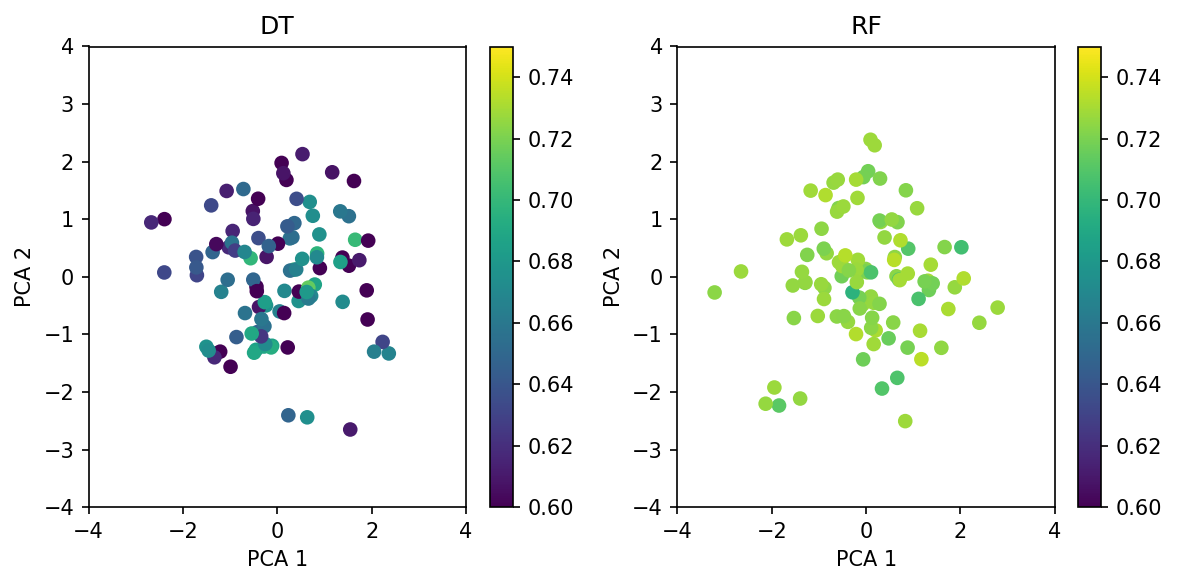

In [37]:
#### YOUR CODE STARTS HERE ####
#
# Points: 1 point
#
# Visualize your experimental results in the PCA space using scatterplot matching the one below as close as possible.
# Set colorbar parameters to be between 0.6 and 0.75

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
sc1 = axes[0].scatter(dt_df['pca1'], dt_df['pca2'], c=dt_df['mean_score'], cmap='viridis', vmin=0.6, vmax=0.75)
axes[0].set_title('DT')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
cbar1 = plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(rf_df['pca1'], rf_df['pca2'], c=rf_df['mean_score'], cmap='viridis', vmin=0.6, vmax=0.75)
axes[1].set_title('RF')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
cbar2 = plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()

#### YOUR CODE ENDS HERE ####

### 3.6. Task 4: Analysis of experimental data (6 points)

Let us think for a bit: it looks like RF is a much more stable algorithm. It also works better. Your final task, is to evaluate quantitatively:

1) Does RF work **on average better** than the decision tree regardless hyperparameters on the KOA progression prediction problem?
2) Is RF more stable than DT when it comes to hyperparameter choice?

You should conduct a permutation test to make your assessmemt.

In [38]:
#### YOUR CODE STARTS HERE ####
#
# Points: 5 points
#
# Design a permutation test function that can work for any test statistic
#
# In our case, we will be have two statistic:
# 1. The average of average scores
# 2. The variance of the average scores
# Your code needs to be general
# You need to run it in two separate cells for RF and DT

def permutation_test(group1_scores, group2_scores, stat_func, n_permutations=1000):
    rng = np.random.default_rng(SEED)
    # observed statistic (true diff in means or vars)
    observed_stat = stat_func(group1_scores, group2_scores)

    # create null hypothesis scenario combining all observations and assume no group difference
    combined_scores = np.concatenate([group1_scores, group2_scores])
    n1 = len(group1_scores)

    count = 0
    for _ in range(n_permutations):
        # simulate the null hypothesis by permuting the combined scores
        perm_idx = rng.permutation(len(combined_scores))
        # task the first n1 as group 1, the rest as group 2
        perm_g1 = combined_scores[perm_idx[:n1]]
        perm_g2 = combined_scores[perm_idx[n1:]]
        # calculate the statistic for the permuted groups
        perm_stat = stat_func(perm_g1, perm_g2)
        if perm_stat >= observed_stat:
            count += 1

    # p-value with continuity correction
    p_value = (count + 1) / (n_permutations + 1)

    return observed_stat, p_value

#### YOUR CODE ENDS HERE ####

In [39]:
# testing if RF worked best on average regardless of hyperparameters
rf_scores = rf_df['mean_score'].values
print(f"RF mean score: {np.mean(rf_scores):.4f} ± {np.std(rf_scores, ddof=1):.4f}")
dt_scores = dt_df['mean_score'].values
print(f"DT mean score: {np.mean(dt_scores):.4f} ± {np.std(dt_scores, ddof=1):.4f}")

# stat: positive if RF > DT on average
mean_stat = lambda rf, dt: np.mean(rf) - np.mean(dt)
obs_diff, p_val = permutation_test(rf_scores, dt_scores, mean_stat, n_permutations=1000)

print(f"Observed mean diff (RF - DT): {obs_diff:.4f}")
print(f"P-value: {p_val:.4f}")

RF mean score: 0.7238 ± 0.0067
DT mean score: 0.6403 ± 0.0400
Observed mean diff (RF - DT): 0.0836
P-value: 0.0010


In [40]:
# Testing if RF scores vary less than the scores of DT
print(f"RF score variance: {np.var(rf_scores, ddof=1):.4f}")
print(f"DT score variance: {np.var(dt_scores, ddof=1):.4f}")
var_stat = lambda rf, dt: np.var(dt, ddof=1) - np.var(rf, ddof=1)
obs_var_diff, p_var = permutation_test(rf_scores, dt_scores, var_stat, n_permutations=1000)

print(f"Observed var diff (DT - RF): {obs_var_diff:.4f}")
print(f"P-value (RF more stable): {p_var:.4f}")

RF score variance: 0.0000
DT score variance: 0.0016
Observed var diff (DT - RF): 0.0016
P-value (RF more stable): 0.0010


What are your conclusions after running the tests? What is more stable, RF or DT? What is better on average? Write your answer with the p-values for each test in the box below.

In [41]:
#### YOUR ANSWER STARTS HERE ####
#
# Points: 1 point
#
# Write your answer here.

# The two permutation tests show that the Random Forest is both more accurate and more stable than the Decision Tree:
# - average performance: the mean ROC-AUC of RF (0.7238) is significantly higher than the one of DT (0.6403), with a p-value of 0.0010. This indicates that RF consistently outperforms DT across different hyperparameter settings.
# - stability: the variance of ROC-AUC scores for RF (0.0000) is lower than the one of DT (0.0016), with a p-value of 0.0010. This suggests that RF's performance is more consistent and less sensitive to hyperparameter changes compared to DT.
# Therefore, we can conclude that RF is the superior model in this experimental setup, being both more accurate and more reliable than DT.

#### YOUR ANSWER ENDS HERE ####